# Chatbot

### Importing the libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, MaxPool1D, concatenate, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model,Sequential
import numpy as np
import pickle
import os

In [2]:
file = open("witty.txt", "r")

In [3]:
dataset = file.read().split('\n')
dataset[:2]

['Can you ask me something about me?', "Nah, I'm good."]

In [4]:
questions = []
response = []

for j, i in enumerate(dataset):
    if j%2==0 or j==0:
        questions.append(i)
    else:
        response.append(i)
        
questions = np.array(questions)
response = np.array(response)

In [5]:
print("Question 1: ", questions[0])
print("Answer 1: ", response[0])

Question 1:  Can you ask me something about me?
Answer 1:  Nah, I'm good.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(questions, response, test_size=0.20)

In [7]:
# tokenizing the input string with Tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, filters="")
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

print("No. of datapoints in X_train :",len(X_train))
print("No. of datapoints in X_test :",len(X_test))
print("Shape of Y_train :",y_train.shape)
print("Shape of Y_test :",y_test.shape)

No. of datapoints in X_train : 7836
No. of datapoints in X_test : 1960
Shape of Y_train : (7836,)
Shape of Y_test : (1960,)


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
Y_train = np_utils.to_categorical(encoded_y_train)
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)
Y_test = np_utils.to_categorical(encoded_y_test)

Using TensorFlow backend.


In [9]:
# To Determine Max Length I will be be considering the 90th percentile and limiting my max_length to 2000

length = []

for i in X_train:
    length.append(int(len(i)))

length.sort()
length = np.array(length)

for i in np.arange(90,100):
    percentile = int(np.percentile(length,i))
    print(f'{i} percentile {percentile}')

90 percentile 35
91 percentile 36
92 percentile 36
93 percentile 37
94 percentile 38
95 percentile 39
96 percentile 40
97 percentile 41
98 percentile 43
99 percentile 46


In [10]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

word_index = tokenizer.word_index
print(len(word_index))
max_length = 46
encoded_train = pad_sequences(sequences_train,maxlen=max_length,padding='post')
encoded_test = pad_sequences(sequences_test, maxlen=max_length,padding='post')

print('Shape of train data tensor:', encoded_train.shape)
print('Shape of test data tensor:', encoded_test.shape)

3108
Shape of train data tensor: (7836, 46)
Shape of test data tensor: (1960, 46)


In [11]:
expend_train = np.expand_dims(encoded_train,2)
expend_test = np.expand_dims(encoded_test,2)
expend_train.shape

(7836, 46, 1)

In [12]:
f = open("glove_vectors","rb")
words = pickle.load(f)

vocab_size=5000
num_words = min(vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
# Checking if the words are in embedding

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = words.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Model:

In [13]:
input = Input(shape=(max_length, ), name="input")

Emb = Embedding(num_words, 2000, input_length = max_length, name="Embedded")(input)

conv1 = Conv1D(filters=4, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv1")(Emb)
conv2 = Conv1D(filters=8, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv2")(Emb)
conv3 = Conv1D(filters=12, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv3")(Emb)

# concat1 = Concatenate()([conv1, conv2, conv3])
concat1 = concatenate([conv1, conv2, conv3])
maxpool1 = MaxPool1D(3)(concat1)
dropout1 = Dropout(0.10, name="Dropout1")(maxpool1)

conv4 = Conv1D(filters=4, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv4")(dropout1)
conv5 = Conv1D(filters=8, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv5")(dropout1)
conv6 = Conv1D(filters=12, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv6")(dropout1)

concat2 = concatenate([conv4, conv5, conv6])
maxpool2 = MaxPool1D(3)(concat2)
dropout2 = Dropout(0.10, name="Dropout2")(maxpool2)

conv7 = Conv1D(filters=12, kernel_size=3, activation='relu',kernel_initializer="he_normal", name="conv7")(dropout2)
flatten = Flatten(name="Flatten")(conv7)
dropout = Dropout(0.10, name="Dropout3")(flatten)

Dense1 = Dense(50, activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(dropout)

output = Dense(len(set(y_train)), activation='softmax', name="output")(Dense1)

model = Model(inputs=input,outputs=output)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 46)]         0                                            
__________________________________________________________________________________________________
Embedded (Embedding)            (None, 46, 2000)     6218000     input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 44, 4)        24004       Embedded[0][0]                   
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 44, 8)        48008       Embedded[0][0]                   
______________________________________________________________________________________________

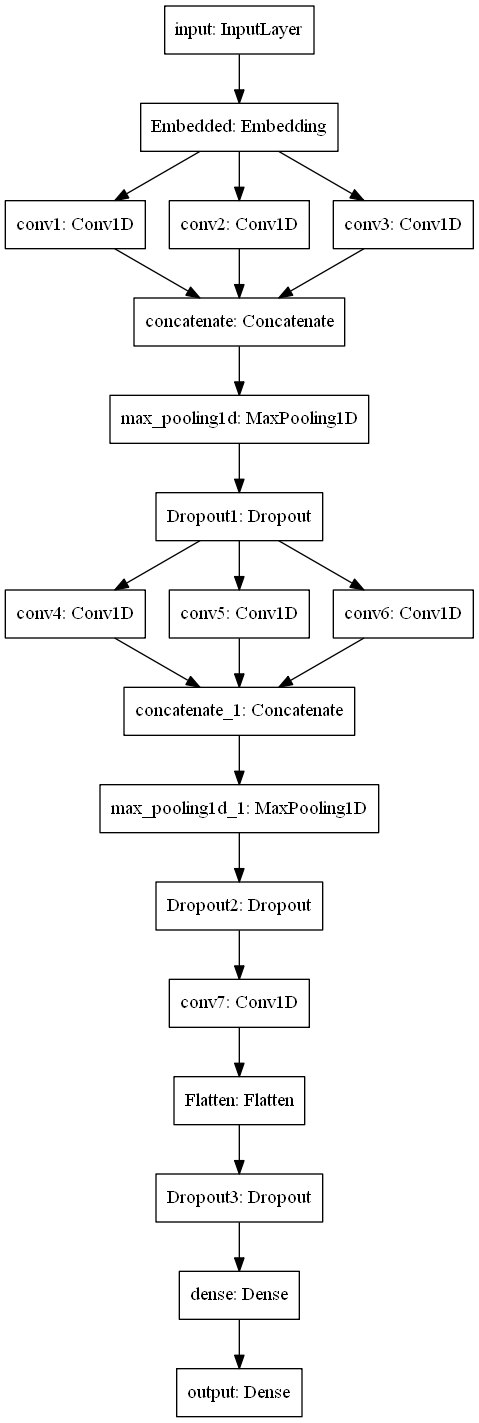

In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("chatbot.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsbot'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile the Model:

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

### Fit the Model:

In [18]:
model.fit(encoded_train, Y_train, 
          validation_data=(encoded_test, Y_test), 
          epochs=50,
          batch_size=256,
          callbacks=[checkpoint, reduce, tensorboard_Visualization])

Train on 7836 samples, validate on 1960 samples
Epoch 1/50
7680/7836 [============================>.] - ETA: 0s - loss: 4.5234 - accuracy: 0.0135
Epoch 00001: val_loss improved from inf to 4.38332, saving model to chatbot.h5
7836/7836 [==============================] - 9s 1ms/sample - loss: 4.5213 - accuracy: 0.0134 - val_loss: 4.3833 - val_accuracy: 0.0260
Epoch 2/50
7680/7836 [============================>.] - ETA: 0s - loss: 4.2095 - accuracy: 0.0658
Epoch 00002: val_loss improved from 4.38332 to 3.88367, saving model to chatbot.h5
7836/7836 [==============================] - 5s 653us/sample - loss: 4.2029 - accuracy: 0.0666 - val_loss: 3.8837 - val_accuracy: 0.0995
Epoch 3/50
7680/7836 [============================>.] - ETA: 0s - loss: 3.6959 - accuracy: 0.1272
Epoch 00003: val_loss improved from 3.88367 to 3.32038, saving model to chatbot.h5
7836/7836 [==============================] - 5s 642us/sample - loss: 3.6886 - accuracy: 0.1286 - val_loss: 3.3204 - val_accuracy: 0.2071
Epoc

7680/7836 [============================>.] - ETA: 0s - loss: 0.8355 - accuracy: 0.7698
Epoch 00027: val_loss did not improve from 1.52241
7836/7836 [==============================] - 4s 553us/sample - loss: 0.8328 - accuracy: 0.7698 - val_loss: 1.5664 - val_accuracy: 0.7423
Epoch 28/50
7680/7836 [============================>.] - ETA: 0s - loss: 0.7824 - accuracy: 0.7842
Epoch 00028: val_loss did not improve from 1.52241
7836/7836 [==============================] - 4s 547us/sample - loss: 0.7833 - accuracy: 0.7845 - val_loss: 1.5910 - val_accuracy: 0.7388
Epoch 29/50
7680/7836 [============================>.] - ETA: 0s - loss: 0.7824 - accuracy: 0.7809
Epoch 00029: val_loss did not improve from 1.52241
7836/7836 [==============================] - 4s 550us/sample - loss: 0.7858 - accuracy: 0.7805 - val_loss: 1.6077 - val_accuracy: 0.7444
Epoch 30/50
7680/7836 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.7915
Epoch 00030: val_loss did not improve from 1.52241
7

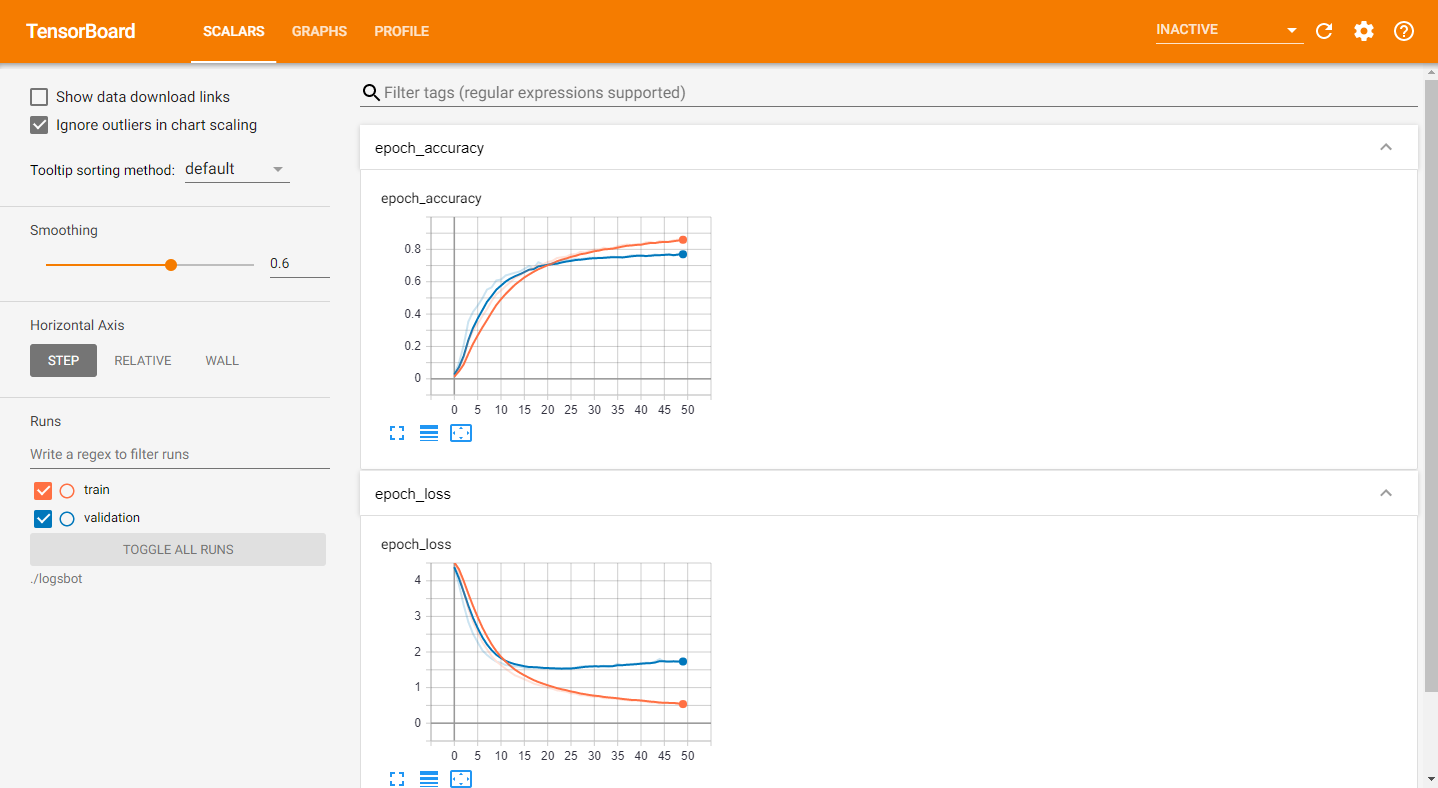

In [20]:
from IPython.display import Image 

# tensorboard --logdir="./logsbot"
# http://DESKTOP-U3TSCVT:6006/

pil_img = Image(filename='graphs.png')
display(pil_img)

## Observation:
### We are able to achieve an overall high accuracy and validation accuracy and an overall low loss as well as validation loss. 